In [4]:
import sys

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import scipy.io as sio
from scipy.special import hankel1, hankel2
from skopt.plots import plot_convergence, plot_gaussian_process, plot_objective, plot_objective_2D
from skopt.space import Categorical, Integer, Real
from skopt.utils import use_named_args
from skopt import gp_minimize

sys.path.insert(0, '/Users/williamjenkins/Research/Code/TritonOA')

from TritonOA.env import env
from TritonOA.models import kraken
from TritonOA.plotting import plotting
from TritonOA.io import readwrite
from TritonOA.sp import signal

## 1. Define True Acoustic Field

### 1.1 Set Model Configuration

In [5]:
parameters = dict()

# Set Run Type =======================================================================
parameters['fullfield'] = True
parameters['TITLE'] = 'TestMFP'

# Define Geometry ====================================================================
parameters['NMEDIA'] = 1
parameters['ZB'] = 300 # Bottom depth (m)
parameters['NZ'] = 301 # Number of depth points
parameters['Z'] = np.linspace(0, parameters['ZB'], parameters['NZ']) # Depth vector (m)
parameters['RMAX'] = 10 # Maximum range (km)
parameters['dR'] = 1 # Range step (m)
parameters['R'] = np.arange(10, 1000 * parameters['RMAX'] + parameters['dR'], parameters['dR']) # Range vector (m)
parameters['NR'] = len(parameters['R']) # Number of range points
# parameters['X'] = np.arange(0, parameters['RMAX'], 0.001)  # <-------------------------------- ***
parameters['NMESH'] = 0

# Define Source/Receiver ============================================================
# parameters['SD'] = 50
# parameters['SR'] = 
parameters['NSD'] = 1
parameters['RD'] = np.linspace(10, 80, 15)
# parameters['RD'] = np.linspace(94.125, 212.25, 64)
parameters['NRD'] = len(parameters['RD'])
parameters['FREQ'] = 100

# Define Top Boundary =========================================================
parameters['TOPOPT'] = "CVW" # C = Linear SSP interp; V = Vacuum in upper halfspace; W = Wavelength-dependent Attenuation (dB/lambda)
parameters['SIGMA_TOP'] = 0 # RMS roughness (m)

# Define Sound Speed Profile ================================================
# SSP_TYPE = "isospeed"
# [parameters.update({k: v}) for k, v in env.default_SSP(SSP_TYPE, parameters['Z'], CP=1500, RHO=1000, AP=0).items()]
# [print(k, v) for k, v in env.default_SSP(SSP_TYPE, parameters['Z'], CP=1500, RHO=1000, AP=0).items()]
SSP_TYPE = "negative"
[parameters.update({k: v}) for k, v in env.default_SSP(SSP_TYPE, parameters['Z'], CP=1490, dC=20, RHO=1000, AP=0).items()]
# [print(k, v) for k, v in env.default_SSP(SSP_TYPE, parameters['Z'], CP=1490, dC=20, RHO=1000, AP=0).items()]

# Define Bottom Boundary ======================================================
parameters['BOTOPT'] = "A" # A = Acousto-elastic halfspace
parameters['SIGMA_BOT'] = 0 # RMS roughness (m)
parameters['CPB'] = 1800 # P-wave speed (m/s)
parameters['CSB'] = 400 # S-wave speed (m/s)
parameters['RHOB'] = 1.8 # Density (g/cm3)
parameters['APB'] = 0.2 # P-wave attenuation (dB/kmHz)
parameters['ASB'] = 0.5 # S-wave attenuation (dB/kmHz)

# Phase Speed Limits ============================================================
parameters['CLOW'] = 0 # Lower phase speed limit (m/s)
parameters['CHIGH'] = parameters['CPB']  # Upper phase speed limit (m/s)

fname = 'parameters.p'
_ = readwrite.dict2pkl(parameters, fname)

### 1.2 Calculate Replica Field

In [6]:
%%capture cap --no-stderr

P, _ = kraken.build_replica_field(parameters, verbose=False)
# np.save(f'replicas_{parameters["FREQ"]}', P)    

100%|██████████| 301/301 [00:31<00:00,  9.46it/s]


In [7]:
with open(f"{parameters['TITLE']}.prt") as f:
    print(f.read())

 _________________________________________________
 
 KRAKENC-TestMFP                                                                
  
 Nominal Frequency =   100.0    Hz
 NMedia    =   1

 
     C-Linear approximation to SSP
     Attenuation units: dB/wavelength


   z (m)     alphaR (m/s)   betaR  rho (g/cm^3)  alphaI     betaI

     VACUUM

       ( # mesh points =     0  RMS roughness =   0.00     m )
      0.00      1500.00      0.00   ******       0.0000    0.0000
      1.00      1499.93      0.00   ******       0.0000    0.0000
      2.00      1499.87      0.00   ******       0.0000    0.0000
      3.00      1499.80      0.00   ******       0.0000    0.0000
      4.00      1499.73      0.00   ******       0.0000    0.0000
      5.00      1499.67      0.00   ******       0.0000    0.0000
      6.00      1499.60      0.00   ******       0.0000    0.0000
      7.00      1499.53      0.00   ******       0.0000    0.0000
      8.00      1499.47      0.00   ******       0.0000    0.0

### 1.3 Check Replica Field

In [8]:
p = P[:, 2000, :]

theta = np.linspace(-90, 90, 361)
sin_theta = np.sin(theta * np.pi / 180)
sin_theta = np.expand_dims(sin_theta, 1).T
zr = np.expand_dims(parameters['RD'], 1)

l = 1490 / parameters['FREQ']

sensing_matrix = np.exp(-1j * 2 * np.pi / l * zr * sin_theta) / np.sqrt(parameters['NRD'])
B_bart = sensing_matrix.conj().T @ p
log_B_bart = 10 * np.log10(np.square(abs(B_bart)) / np.max(np.square(abs(B_bart))))

# fig1 = plt.figure()
# plt.imshow(
#     log_B_bart,
#     aspect='auto',
#     extent=[parameters['R'].min(), parameters['R'].max(), theta.min(), theta.max()],
#     interpolation=None,
#     origin='lower'
# )
# plt.gca().invert_yaxis()
# plt.xlabel('Range (m)')
# plt.ylabel('Grazing Angle (deg)')
# plt.colorbar()

fig2 = plt.figure(figsize=(4,6))
# range_index = np.where(parameters['R'] == 10000)
range_index = np.where(np.isclose(parameters['R'], 2500, atol=2) == True)
plt.plot(log_B_bart[:, range_index].squeeze(), theta)
plt.ylim([-90, 90])
plt.yticks(ticks=np.linspace(-90, 90, 5))
plt.gca().invert_yaxis()
plt.xlabel('Normalized Amplitude (dB)')
plt.ylabel('Grazing Angle (deg)')
plt.title(f'Range = {parameters["R"][range_index].squeeze()} m')
plt.show()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 301 is different from 15)

In [ ]:
pressure = P[:, :, 6]
# pressure = abs(test[:, :, 0])
# logpressure = np.log10(abs(pressure))
logpressure = 10*np.log10(np.square(abs(pressure)) / np.max(np.square(abs(pressure))))

levs = np.linspace(logpressure.min(), logpressure.max(), 100)

vmin = -60
vmax = 0
pos.r.range
pos.r.depth
plt.contourf(parameters['R'], parameters['Z'], (logpressure), levels=levs, cmap="jet", vmin=vmin, vmax=vmax)
# plt.contourf(parameters['R'], parameters['Z'], (logpressure), cmap="jet", vmin=vmin, vmax=vmax)
# plt.contourf(parameters['R'], parameters['Z'], (logpressure), cmap="jet")
plt.gca().invert_yaxis()
plt.xlabel("Range (m)")
plt.ylabel("Depth (m)")
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
# cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_spec))
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="jet"))
# cbar.set_label("SPL (dB)")

## 2. Matched Field Processing

### 2.1 Calculate Received (Actual) Pressure Field

In [5]:
sd = 40
sr = 4700

sd_ind = np.where(parameters['Z'] == sd)
sr_ind = np.where(np.isclose(parameters['R'], sr, atol=parameters['dR']/2))
# sr_ind = np.where(parameters['R'] == sr)

received = np.moveaxis(
    P[sd_ind, sr_ind, :].squeeze(axis=0),
    0, -1
)

# noise = 1. * (np.random.randn(15,1) + 1j * np.random.randn(15,1))
noise = 0
received += noise

K = received @ received.conj().T
np.save('received', received)

### 2.2 Perform Grid Search

In [211]:
# depth_lim = (0, 100)
# range_lim = (3500, 5500)

# rvec = parameters['R']
# zvec = parameters['Z']
rvec = np.linspace(2500, 6500, 4001)
zvec = np.linspace(0, 100, 101)
B = np.zeros((len(zvec), len(rvec)))

for nn, r in enumerate(rvec):
    for mm, z in enumerate(zvec):
        received_hat = P[np.where(parameters['Z'] == z), np.where(parameters['R'] == r), :].squeeze()
        B[mm, nn] = signal.bartlett(K, received_hat)

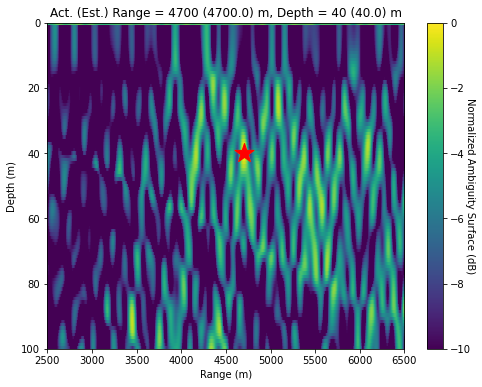

In [219]:
# r_hat = received_hat

# # Method 1
# w = r_hat / np.linalg.norm(r_hat)
# B1 = abs(w.conj().T @ K @ w)
# phi1 = np.trace(K) - B1

# # Method 2
# w = r_hat
# B2 = w.conj().T @ K @ w / (w.conj().T @ w)
# phi2 = np.trace(K) - B2

# print(phi1, phi2)

# phi = np.real(np.trace(K) - B)
# plt.imshow(phi, aspect='auto', origin='lower')
# plt.colorbar()

# Bnorm = 10 * np.log10(B / B.max())


# print(Bnorm.shape, rvec.shape, zvec.shape)
fig = plotting.plot_MFP(B, rvec, zvec, sr=sr, sd=sd, figsize=(8, 6))

In [228]:
fig.savefig('MFP_presentation_compare.pdf', dpi=300, facecolor='w', bbox_inches='tight')

# J = 5
# phi_ml = phi.min()

# L = np.exp(-J * (phi - phi_ml) / phi_ml)

# L.max()

# # plt.imshow(np.log(L), aspect='auto', origin='lower')
# # plt.colorbar()

## 3. Estimate Depth & Range Using GP

### 3.1 Define Parameter Space

In [143]:
space = [
    Real(2500, 6500, name='Source_Range'),
    Real(1, 100, name='Source_Depth'),
#     Real(1700, 1900, name='Bottom_Speed')
]

# space = [
#     Integer(1000, 5000, name='sr'),
#     Integer(1, 100, name='sd'),
# ]

In [144]:
# @use_named_args(space)
# def gp_loop(sr, sd):
#     # 1. Load data
#     data = sio.loadmat('zreplica_250.mat')
#     p = data['p1']
#     range_vec = data['rr'].squeeze().round().astype(int)
#     depth_vec = data['rd'].squeeze().round().astype(int)
#     receiver_depths = data['sd'].squeeze()
    
#     # 2. Specify source information
#     true_range = 3.e3
#     true_depth = 40.
#     r = np.expand_dims(p[np.where(depth_vec==true_depth), np.where(range_vec==true_range), :].squeeze(), axis=1)
    
#     # 3. Retrieve replica field for given test source range and depth:
#     test_range = sr
#     test_depth = sd
#     print(f"Range = {test_range}, Depth = {test_depth}")
#     ind_depth = np.where(depth_vec==test_depth)
#     ind_range = np.where(range_vec==test_range)
#     r_hat = np.expand_dims(p[ind_depth, ind_range, :].squeeze(), axis=1) # -> [0, 1, 16]
#     print(r_hat.shape)
    
#     # 4. Calculate Bartlett Objective Function:
#     K = r @ r.conj().T
#     w = r_hat / np.linalg.norm(r_hat)
#     B = np.real(w.conj().T @ K @ w)
# #     traceK = np.trace(K).squeeze()
# #     loss = float(np.log(np.real(traceK - B)))
#     loss = float(B)
    
#     return loss


@use_named_args(space)
def gp_loop(Source_Range=2500, Source_Depth=50, Bottom_Speed=None):
    # 1. Load & update model configuration, load received field
    parameters = readwrite.pkl2dict(fname)
    parameters['SD'] = Source_Depth # Source Depth (m)
    parameters['R'] = Source_Range # Source Range (m)
    if Bottom_Speed is not None:
        parameters['CPB'] = Bottom_Speed
    
    p_rec = np.load('received.npy')
    
    # 2. Calculate modes for this source depth
    _, _ = kraken.run_kraken(parameters)
    phi_src, phi_rec, k, _ = readwrite.format_modes(parameters)
    
    # 3. For this source depth & source range, calculate replica field:
    replica = signal.pressure_field(phi_src, phi_rec, k, parameters['R'])
    
    # 4. Calculate Bartlett Function:
    K = received @ received.conj().T
    B = signal.bartlett(K, replica).squeeze()
    
    # 5. Transform Bartlett Output to Loss Function:
    # tr(K) - w.T * K * w
    traceK = np.trace(K).squeeze()
    loss = float(-B)
#     loss = float(np.real(traceK - B))

    return loss #, traceK, B

### 3.2 Search for Optimal Parameters

In [145]:
result_gp = gp_minimize(
    gp_loop,
    space,
    acq_func="EI",
    n_calls=200,
    n_initial_points=16,
    initial_point_generator="sobol",
    random_state=2009,
    verbose=True,
    xi=1
)

# print(f'   Actual Values: Range = {sr} m, Depth = {sd} m')
# print(f'Estimated Values: Range = {result_gp.x[0]:.0f} m, Depth = {result_gp.x[1]:.0f} m')

Iteration No: 1 started. Evaluating function at random point.
0
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0637
Function value obtained: -1.5893
Current minimum: -1.5893
Iteration No: 2 started. Evaluating function at random point.
0
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0500
Function value obtained: -2.6855
Current minimum: -2.6855
Iteration No: 3 started. Evaluating function at random point.
0
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0467
Function value obtained: -2.6288
Current minimum: -2.6855
Iteration No: 4 started. Evaluating function at random point.
0
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0453
Function value obtained: -5.2548
Current minimum: -5.2548
Iteration No: 5 started. Evaluating function at random point.
0
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0430
Function value obtained: -2.2986
Current minimum: -5.2548
Iteration No: 6

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 0.5430
Function value obtained: -5.6799
Current minimum: -9.9314
Iteration No: 42 started. Searching for the next optimal point.
0
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 0.6414
Function value obtained: -0.7119
Current minimum: -9.9314
Iteration No: 43 started. Searching for the next optimal point.
0
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 0.6418
Function value obtained: -0.6135
Current minimum: -9.9314
Iteration No: 44 started. Searching for the next optimal point.
0
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 0.8641
Function value obtained: -5.4005
Current minimum: -9.9314
Iteration No: 45 started. Searching for the next optimal point.
0
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 0.6195
Function value obtained: -5.8678
Current minimum: -9.9314
Iteration N

Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 0.7270
Function value obtained: -2.9532
Current minimum: -11.8016
Iteration No: 81 started. Searching for the next optimal point.
0
Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 0.9029
Function value obtained: -2.5688
Current minimum: -11.8016
Iteration No: 82 started. Searching for the next optimal point.
0
Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 0.9256
Function value obtained: -9.7156
Current minimum: -11.8016
Iteration No: 83 started. Searching for the next optimal point.
0
Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 0.9519
Function value obtained: -7.4809
Current minimum: -11.8016
Iteration No: 84 started. Searching for the next optimal point.
0
Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 0.8420
Function value obtained: -15.4858
Current minimum: -15.4858
Itera

Iteration No: 119 ended. Search finished for the next optimal point.
Time taken: 1.3281
Function value obtained: -0.6741
Current minimum: -16.9224
Iteration No: 120 started. Searching for the next optimal point.
0
Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 1.2866
Function value obtained: -2.8469
Current minimum: -16.9224
Iteration No: 121 started. Searching for the next optimal point.
0
Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 1.3779
Function value obtained: -6.8687
Current minimum: -16.9224
Iteration No: 122 started. Searching for the next optimal point.
0
Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 1.4272
Function value obtained: -0.2792
Current minimum: -16.9224
Iteration No: 123 started. Searching for the next optimal point.
0
Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 1.4727
Function value obtained: -2.4144
Current minimum: -16.92

Iteration No: 158 ended. Search finished for the next optimal point.
Time taken: 2.0347
Function value obtained: -5.7304
Current minimum: -16.9224
Iteration No: 159 started. Searching for the next optimal point.
0
Iteration No: 159 ended. Search finished for the next optimal point.
Time taken: 1.9767
Function value obtained: -1.9457
Current minimum: -16.9224
Iteration No: 160 started. Searching for the next optimal point.
0
Iteration No: 160 ended. Search finished for the next optimal point.
Time taken: 2.5718
Function value obtained: -3.8670
Current minimum: -16.9224
Iteration No: 161 started. Searching for the next optimal point.
0
Iteration No: 161 ended. Search finished for the next optimal point.
Time taken: 1.8083
Function value obtained: -0.7762
Current minimum: -16.9224
Iteration No: 162 started. Searching for the next optimal point.
0
Iteration No: 162 ended. Search finished for the next optimal point.
Time taken: 2.0679
Function value obtained: -1.7486
Current minimum: -16.92

Iteration No: 197 ended. Search finished for the next optimal point.
Time taken: 2.3109
Function value obtained: -0.2398
Current minimum: -16.9224
Iteration No: 198 started. Searching for the next optimal point.
0
Iteration No: 198 ended. Search finished for the next optimal point.
Time taken: 2.7860
Function value obtained: -2.1613
Current minimum: -16.9224
Iteration No: 199 started. Searching for the next optimal point.
0
Iteration No: 199 ended. Search finished for the next optimal point.
Time taken: 3.0870
Function value obtained: -0.1787
Current minimum: -16.9224
Iteration No: 200 started. Searching for the next optimal point.
0
Iteration No: 200 ended. Search finished for the next optimal point.
Time taken: 2.8357
Function value obtained: -0.5964
Current minimum: -16.9224


   Actual Values: Range = 4700 m, Depth = 40 m, Bottom Speed = 1800 m/s
Estimated Values: Range = 4697 m, Depth = 40 m


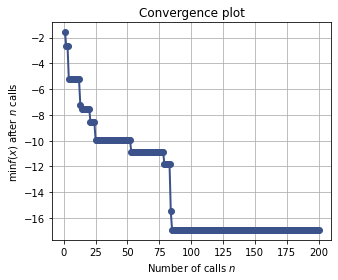

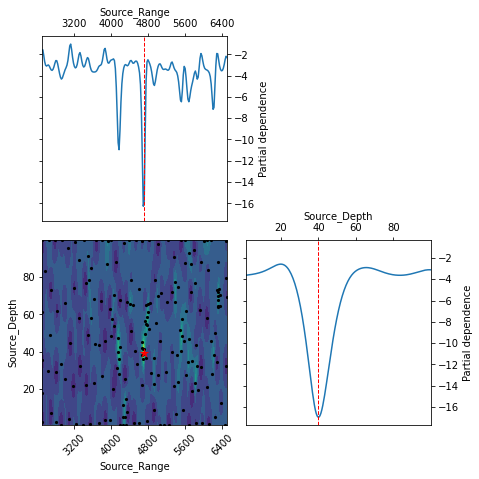

In [148]:
print(f'   Actual Values: Range = {sr} m, Depth = {sd} m, Bottom Speed = 1800 m/s')
print(f'Estimated Values: Range = {result_gp.x[0]:.0f} m, Depth = {result_gp.x[1]:.0f} m')
# print(f'Estimated Values: Range = {result_gp.x[0]:.0f} m, Depth = {result_gp.x[1]:.0f} m, Bottom Speed = {result_gp.x[2]:.0f} m/s')

fig1 = plt.figure(figsize=(5,4))
plot_convergence(result_gp)
plt.show()

ax = plot_objective(result_gp, sample_source='result', n_points=200, size=3)

In [209]:
fig1.savefig('convplot_presentation2.pdf', dpi=300, facecolor='w')
ax.flatten()[0].figure.savefig('partialdependence_presentation2.pdf', dpi=300, facecolor='w', bbox_inches="tight")

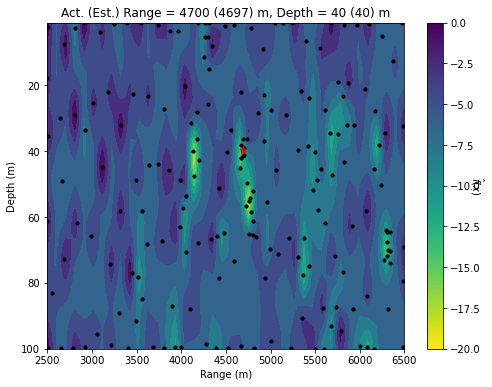

In [226]:
import matplotlib as mpl

fig3 = plt.figure(figsize=(8, 6))
_ = plot_objective_2D(result=result_gp,
                      dimension_identifier1='Source_Range',
                      dimension_identifier2='Source_Depth')
plt.gca().invert_yaxis()

norm = mpl.colors.Normalize(vmin=-20, vmax=0)
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis_r'))
cbar.set_label('$\hat{f}(x)$', rotation=270)

plt.xlabel('Range (m)')
plt.ylabel('Depth (m)')
plt.title(f'Act. (Est.) Range = {sr} ({result_gp.x[0]:.0f}) m, Depth = {sd} ({result_gp.x[1]:.0f}) m')
plt.show()

In [227]:
fig3.savefig('bogp_result_compare.pdf', dpi=300, facecolor='w', bbox_inches='tight')

# model = result_gp.models[-1]

# x1_model = np.linspace(2500, 6500, 401)
# x2_model = np.linspace(0, 100, 101)
# X, Y = np.meshgrid(x1_model, x2_model)

# positions = np.vstack([X.ravel(), Y.ravel()])

# y_pred, sigma = model.predict(positions.T, return_std=True)

array([-3.88077464, -3.88077464, -3.88077464, ..., -3.88077464,
       -3.88077464, -3.88077464])

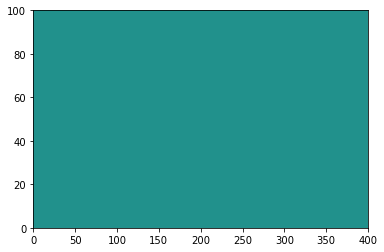

In [208]:
test = np.reshape(y_pred, X.shape)
test.shape

plt.contourf(test)

test.min()

y_pred

# fig3, (ax1, ax2) = plt.subplots(2, 1)

## 4. Estimate Range Using GP

### 4.1 Define Parameter Space

In [ ]:
parameters['R'] = sr
parameters['SD'] = sd
_ = readwrite.dict2pkl(parameters, fname)

space = [
    Real(100, 1000*parameters['RMAX'], name='sr'),
#     Real(0, parameters['ZB'], name='sd'),
]

In [ ]:
@use_named_args(space)
def gp_loop(sr=sr, sd=sd):
    # 1. Load & update model configuration, load received field
    parameters = readwrite.pkl2dict(fname)
#     parameters['SD'] = sd # Source Depth (m)
    parameters['R'] = sr # Source Range (m)
    
    p_rec = np.load('received.npy')
    
    # 2. Calculate modes for this source depth
    _, _ = kraken.run_kraken(parameters)
    phi_src, phi_rec, k, _ = readwrite.format_modes(parameters)
    
    # 3. For this source depth & source range, calculate replica field:
    replica = signal.pressure_field(phi_src, phi_rec, k, parameters['R'])
    
    # 4. Calculate Bartlett Function:
    K = received @ received.conj().T
    B = bartlett(K, replica)
    
    # 5. Transform Bartlett Output to Loss Function:
    loss = -10*np.log10(B)
    
#     print('sr =', sr, 'sd =', sd, 'loss =', loss, file=sys.stderr)

    return loss

### 4.2 Search for Optimal Parameters

In [ ]:
%%capture cap --no-stderr

CALLS = 200

result_gp = gp_minimize(
    gp_loop,
    space,
    n_calls=CALLS,
    n_initial_points=100,
    random_state=2009
)

In [ ]:
print(f'   Actual: Range = {sr} m')
print(f'Estimated: Range = {result_gp.x[0]:.0f} m')

In [ ]:
fig1 = plt.figure(figsize=(12,9))
plot_convergence(result_gp)
plt.show()


ax = plot_objective(result_gp, sample_source='result', n_points=200, size=4)

In [229]:
# plt.plot(result_gp.x_iter, esult_gp.func_vals)
result_gp.models

# plt.scatter([x[0] for x in result_gp.x_iters], [x[1] for x in result_gp.x_iters])

[GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                          n_restarts_optimizer=2, noise='gaussian',
                          normalize_y=True, random_state=258668026),
 GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                          n_restarts_optimizer=2, noise='gaussian',
                          normalize_y=True, random_state=258668026),
 GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                          n_restarts_optimizer=2, noise='gaussian',
                          normalize_y=True, random_state=258668026),
 GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                          n_restarts_optimizer=2, noise='gaussian',
                          normalize_y=True, random_state=258668026),
 GaussianProcessRegressor(ke

## Appendix A: Test MFP on Swellex Data

In [ ]:
import scipy.io as sio

data = sio.loadmat('zreplica_250.mat')
p1 = data['p1']
rr = data['rr'].squeeze()
rd = data['rd'].squeeze()
sd = data['sd'].squeeze()


sr = 3e3
sd = 40

r = np.expand_dims(p1[np.where(rd==sd), np.where(rr==sr), :].squeeze(), axis=1)
K = r @ r.conj().T

asurf = np.zeros((len(rd), len(rr)))

for mm in range(len(rr)):
    for nn in range(len(rd)):
        asurf[nn, mm] = bartlett(K, p1[nn, mm, :].squeeze())

In [ ]:
nasurf = asurf / np.max(asurf)
lognasurf = 10 * np.log10(nasurf)

fig = plt.figure(figsize=(12,9))
plt.imshow(lognasurf, aspect='auto', origin='lower', extent=[rr.min(), rr.max(), rd.min(), rd.max()], interpolation='none', vmin=-10, vmax=0)
plt.gca().invert_yaxis()
plt.xlabel('Range (m)')
plt.ylabel('Depth (m)')
plt.colorbar()
plt.show()